In [1]:
import requests, json, numpy, datetime
import pywren
import boto3
import numpy as np
from pyproj import Proj
import warnings
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
BUCKET = 'mapping-disaster-risk'

GEOJSONS = ['train-borde_rural.geojson', 'train-borde_soacha.geojson',
            'train-castries.geojson', 'train-dennery.geojson',
            'train-gros_islet.geojson', 'train-mixco_1_and_ebenezer.geojson',
            'train-mixco_3.geojson']

TIFS = ['borde_rural_ortho-cog.tif', 'borde_soacha_ortho-cog.tif',
        'castries_ortho-cog.tif', 'dennery_ortho-cog.tif',
        'gros_islet_ortho-cog.tif', 'mixco_1_and_ebenezer_ortho-cog.tif',
        'mixco_3_ortho-cog.tif']

tif_list = [{'tif':"borde_rural_ortho-cog.tif",
            'crs': 'epsg:32618',
            'geojson': 'train-borde_rural.geojson',
            'output': 'colombia_rural_zonal.csv'},
            {'tif':"borde_soacha_ortho-cog.tif",
            'crs': 'epsg:32618',
            'geojson':'train-borde_soacha.geojson',
            'output': 'colombia_soacha_zonal.csv'},
            {'tif':"mixco_1_and_ebenezer_ortho-cog.tif",
            'crs': 'epsg:32616',
            'geojson': 'train-mixco_1_and_ebenezer.geojson',
            'output': 'guatemala_mixco_1_zonal.csv'},
            {'tif':"mixco_3_ortho-cog.tif",
            'crs': 'epsg:32616',
            'geojson': 'train-mixco_3.geojson',
            'output': 'guatemala_mixco_3_zonal.csv'},
            {'tif':"castries_ortho-cog.tif",
            'crs': 'epsg:32620',
            'geojson': 'train-castries.geojson',
            'output': 'stlucia_castries_zonal.csv'},
            {'tif':"dennery_ortho-cog.tif",
            'crs': 'epsg:32620',
            'geojson': 'train-dennery.geojson',
            'output': 'stlucia_dennery_zonal.csv'},
            {'tif':"gros_islet_ortho-cog.tif",
            'crs': 'epsg:32620',
            'geojson': 'train-gros_islet.geojson',
            'output': 'stlucia_gros_islet_zonal.csv'}]

GEOS = ['train-borde_rural.geojson', 'train-borde_soacha.geojson',
            'train-castries.geojson', 'train-dennery.geojson']

In [3]:
# Note that all geojsonn names are the object names as well, so to access an object call:
# https://mapping-disaster-risk.s3.amazonaws.com/train-borde_rural.geojson

In [99]:
def get_geojsons(dictionary):
    '''
    Creates a boto3 client and gets a geojson object from an s3 bucket.
    Returns the contents of the geojson.
   
    Input:
        dictionary (dict): dictionary of information about an image file
    
    Output:
        geo_json (dict): a json file
    '''
    geojson = dictionary['geojson']

    try:
        s3 = boto3.client('s3', 'us-east-1')
        obj = s3.get_object(Bucket='mapping-disaster-risk', Key=geojson)
        geo_json = json.load(obj['Body'])

    except Exception as e:
        raise e

    return geo_json

### Parallelize and time the data collection process

In [233]:
%%time

pwex = pywren.default_executor()
futures = pwex.map(get_geojsons, [tif_list[3]])
all_geojsons = pywren.get_all_results(futures)

CPU times: user 717 ms, sys: 96.3 ms, total: 813 ms
Wall time: 9.66 s


In [114]:
def make_polygons(geojson):
    '''
    Given a geojson file, extracts relevant information for each
    building, including type, building id, roof material, and coordinates.
    Returns a list of dictionaries, where each dictionary maps a building by
    these features.

    Input:
        geojson (dict): geojson dictionary
    
    Output:
        polygons (lst): a list of dictionaries (one per building)
    '''
    polygons = []

    for feature in geojson['features']:
        polygon = {}
        polygon['type'] = feature['geometry']['type']
        polygon['bid'] = feature['id']
        polygon['roof_material'] = feature['properties']['roof_material']
        polygon['coordinates'] = feature['geometry']['coordinates']
        polygons.append(polygon)

    return polygons

### Parallelize the process to make polygons

In [232]:
%%time

pwex = pywren.default_executor()
futures = pwex.map(make_polygons, all_geojsons)
all_polygons = pywren.get_all_results(futures)

CPU times: user 1.11 s, sys: 166 ms, total: 1.27 s
Wall time: 21.2 s


In [152]:
def transform_coordinates_UML(polygon):
    '''
    Given a polygon with building footprints, executes an affine transformation on each
    coordinate pair to output a new coordinate pair based on a provided
    coordinate reference system (crs) from the corresponding geotiff file.
    Serial since Proj is not natively installed on Lambda.
    
    Input:
        polygon (dict): original dictionary
    
    Output:
        polygon (dict): updated dictionary
    '''
    transform = Proj(init='epsg:32616')
    coordinates_lists = polygon['coordinates']
    transformed_coordinates_lists = []
    
    for coordinates_list in coordinates_lists:
        inner_coord_list = []
        for coordinate in coordinates_list:
            transformed_coordinate = list(transform(coordinate[0],
                                                    coordinate[1]))
            inner_coord_list.append(transformed_coordinate)
        transformed_coordinates_lists.append(inner_coord_list)
    
    polygon['coordinates'] = transformed_coordinates_lists
    
    return polygon

In [156]:
transformed_polygons = []

for polygon in all_polygons[0]:
    transformed = transform_coordinates_UML(polygon)
    transformed_polygons.append(transformed)

In [61]:
def get_rooftop_array_after_mask(polygon):
    '''
    Given a dictionary containing transformed coordinates for one roof,
    returns an array of arrays, each one providing a numeric value for each
    pixel in the image for a specific band (in this case, 4 matrices for 4
    bands).
    
    Eg. Values from 0-255 correspond with the color scale.
    
    Input:
        polygon (dict): a dictionary of features including coordinates for a
                        single building
    Output:
        out_image (numpy array): a numpy of values per pixel for each
                                 band (one per image layer)
    '''
    tiff_path = 'https://mapping-disaster-risk.s3.amazonaws.com/mixco_3_ortho-cog.tif'
    with rasterio.open(tiff_path) as tiff:
        try:
            out_image, out_transform = mask(tiff, [polygon], crop=True)
        except Exception as e:
             pass
        else:
            return out_image

In [160]:
'''
For each polygon in a tif file, extracts the roof that corresponds to the given building's footprint
'''
image_list = []

for polygon in transformed_polygons:
    rv = {}
    array = get_rooftop_array_after_mask(polygon)
    rv['roof_material'] = polygon['roof_material']
    rv['img_array'] = array
    image_list.append(rv)

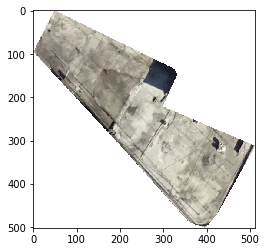

In [239]:
show(image_list[30]['img_array'])

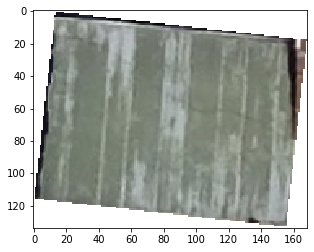

In [163]:
show(image_list[130]['img_array'])

In [178]:
def get_zonals(roof_dict):
    '''
    Given a dictionary that contains the roof material and image array,
    function calculates the median value for the red, green, and 
    blue raster bands present in the image.
    
    Input:
        roof_dict (dict): dictionary
    
    Output:
        dictionary (dict): a dictionary with the buildings material and a list
                           of median array values for each band
    '''   
    material = roof_dict['roof_material']
    roof = roof_dict['img_array']

    zonal_list = []
    for i in range(roof.shape[0] - 1):
        zonal_list.append(np.median(roof[i]))

    return {'material': material, 'stats': zonal_list}

### Parallelize our process to calculate zonal statistics

In [193]:
%%time

pwex = pywren.default_executor()
future = pwex.map(get_zonals, image_list)
all_zonals = pywren.get_all_results(future)

CPU times: user 8.47 s, sys: 2.38 s, total: 10.9 s
Wall time: 1min 1s


### Building the dataframe with zonal stats

This dataframe contains the zonal statistics for every building present in tif files.

In [227]:
# INITIATE THE FIRST ROW OF THE DATAFRAME
first_roof = all_zonals[0]
df = json_normalize(first_roof)
df2 = pd.DataFrame(df["stats"].to_list(), columns = ["band1","band2","band3"])
df3 = df['material']

In [225]:
# BUILD THE FULL DATAFRAME WITH ZONAL STATS OF ALL POLYGONS IN A TIF
# The output can then be passed to our machine learning pipeline!
vertical_stack = pd.concat([df3, df2], axis=1)
for roof in all_zonals[1:]:
    df = json_normalize(roof)
    df2 = pd.DataFrame(df["stats"].to_list(),\
                       columns = ["band1","band2","band3"])
    df3 = df['material']
    horizontal_stack = pd.concat([df3, df2], axis=1)
    vertical_stack = pd.concat([vertical_stack, horizontal_stack], axis=0)

In [226]:
vertical_stack

,material,band1,band2,band3
0,healthy_metal,156.0,167.0,170.0
0,healthy_metal,156.0,167.0,170.0
0,healthy_metal,157.0,160.0,161.0
0,healthy_metal,0.0,0.0,0.0
0,healthy_metal,190.0,192.0,190.0
...,...,...,...,...
0,healthy_metal,199.0,195.0,187.0
0,irregular_metal,103.0,84.0,70.0
0,irregular_metal,0.0,0.0,0.0
0,healthy_metal,0.0,0.0,0.0
